In [32]:
import sys
sys.path.append("../SpikeCounter")
import numpy as np
import skimage.io as skio
import matplotlib as mpl
import matplotlib.pyplot as plt
from tifffile import imsave
import matplotlib.colors as colors
import matplotlib.patches as patches
import os
from scipy import interpolate, optimize, ndimage, stats, signal, fft
from skimage import filters, transform, morphology, exposure, measure
from spikecounter.analysis import traces, images
from spikecounter.analysis import stats as sstats
from spikecounter.ui import visualize, HyperStackViewer
from spikecounter import utils
import colorcet as cc
from cycler import cycler
from scipy.io import loadmat
import mat73
from sklearn.utils.extmath import randomized_svd
import pandas as pd
import parse

# plt.style.use("../bio_pubs_presentation.mplstyle")
plt.style.use("../bio_publications.mplstyle")

1.5V = x mW/mm^2

In [2]:
V0 = 38e-3/(41499*7.048e-8)

In [3]:
V0/1.5*np.array([1,2,3,4])

array([ 8.66141426, 17.32282851, 25.98424277, 34.64565703])

### Load metadata and video

In [4]:
rootdir = "/n/holyscratch01/cohen_lab/bjia/20220301_gtacr_targeted_silencing/"
if not os.path.isdir(os.path.join(rootdir, "analysis")):
    os.mkdir(os.path.join(rootdir, "analysis"))

In [5]:
expt_info = pd.read_csv(os.path.join(rootdir, "analysis", "experiment_data.csv")).sort_values("start_time").reset_index()

In [6]:
expts = expt_info["file_name"]
print(expts)

0                         093224gtacr_E3_excitation
1                        094513gtacr_E12_excitation
2           102152gtacr_E12_pulsed_after_initiation
3               102419gtacr_E12_DC_after_initiation
4      102652gtacr_E12_100ms_pulse_after_initiation
5      102901gtacr_E12_200ms_pulse_after_initiation
6      103025gtacr_E12_500ms_pulse_after_initiation
7     103158gtacr_E12_1000ms_pulse_after_initiation
8                        103454gtacr_E12_endogenous
9                 105012gtacr_E12_silencing_target1
10                105205gtacr_E12_silencing_target2
11         105521gtacr_E12_silencing_target1_larger
12                105645gtacr_E12_silencing_target2
13                105901gtacr_E12_silencing_target3
14                110025gtacr_E12_silencing_target4
15                        111427gtacr_E4_endogenous
16                           112819gtacr_E4_fullfov
17                           113033gtacr_E4_target1
18                      113246gtacr_E4_target1_0.7V
19          

In [463]:
all_embryo_expts = ["105521gtacr_E12_silencing_target1_larger", "105645gtacr_E12_silencing_target2", "105901gtacr_E12_silencing_target3",\
                    "110025gtacr_E12_silencing_target4"]
all_embryo_expts = ["113033gtacr_E4_target1", "114120gtacr_E4_target2_1V", "114432gtacr_E4_target3_2V",\
                    "114001gtacr_E4_target4_1V"]
all_embryo_expts = ["120620gtacr_E3_target1_2V", "120840gtacr_E3_target2_2V", "121100gtacr_E3_target3_2V",\
                    "121311gtacr_E3_target4_2V"]

In [436]:
embryo = "E3"
os.makedirs(os.path.join(rootdir, "analysis", embryo), exist_ok=True)

In [532]:
filename = expts[32]
print(filename)
img, expt_data = images.load_image(rootdir, filename, subfolder="downsampled")
img = images.correct_photobleach(img, method="linear")
traces_dict, t = utils.traces_to_dict(expt_data)
print(t)
print(traces_dict['mod488'])
stim_edges = np.argwhere(np.diff(traces_dict["enable488"]) != 0).ravel()

120840gtacr_E3_target2_2V
[3.675000e-02 5.728000e-02 7.781000e-02 ... 4.495639e+01 4.497692e+01
 4.499745e+01]
[2. 2. 2. ... 2. 2. 2.]


In [533]:
stim_edges = np.argwhere(np.diff(traces_dict["enable488"]) != 0).ravel()

### Get biological landmark

In [358]:
!ls {os.path.join(rootdir, "Snaps")}

085808bluecal.tiff
092200zsyellow_position.tiff
092510E1_frgeco_brightness.tiff
092615E2_frgeco_brightness.tiff
092738E3_frgeco_brightness.tiff
093008E3_nkx_snap.tiff
093649gtacr_E4_frgeco_brightness.tiff
093727gtacr_E5_frgeco_brightness.tiff
093816gtacr_E6_frgeco_brightness.tiff
094033gtacr_E7_frgeco_brightness.tiff
094143gtacr_E9_frgeco_brightness.tiff
094426gtacr_E12_frgeco_brightness.tiff
103454gtacr_E12_endogenous_locus_target.tiff
103454gtacr_E12_endogenous_spike_amplitude.tiff
110357gtacr_E12_nkx.tiff
111427gtacr_E4_endogenous_locus_target.tiff
111427gtacr_E4_endogenous_spike_amplitude.tiff
115015gtacr_E4_nkx.tiff
115154gtacr_E3_endogenous_locus_target.tiff
115154gtacr_E3_endogenous_spike_amplitude.tiff
122249gtacr_E3_nkx.tiff
124257Voltron_Transgenic_JF585.tiff


In [439]:
nkx_path = "122249gtacr_E3_nkx.tiff"
nkx = skio.imread(os.path.join(rootdir, "Snaps", nkx_path))
factor = 4

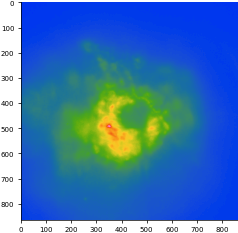

In [440]:
plt.imshow(nkx)

In [441]:
nkx_downsample = transform.downscale_local_mean(nkx, (factor,factor))
offset = [(nkx_downsample.shape[0]-img.shape[1])//2, (nkx_downsample.shape[1]-img.shape[2])//2]
if offset[0] > 0:
    nkx_downsample = nkx_downsample[offset[0]:-offset[0],offset[1]:-offset[1]]

In [442]:
mean_intensity = img.mean(axis=0)

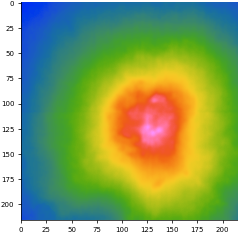

In [443]:
plt.imshow(mean_intensity)

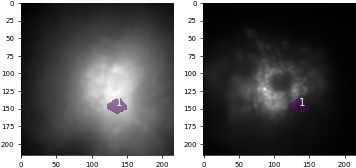

In [444]:
factor = 4
fig1, axes = plt.subplots(1,2, figsize=(6,3))
target_img_space = images.load_dmd_target(rootdir, filename, downsample_factor=factor)
q = visualize.display_roi_overlay(mean_intensity, target_img_space.astype(int), ax=axes[0])
q2 = visualize.display_roi_overlay(nkx_downsample, target_img_space.astype(int), ax=axes[1])

In [464]:
all_targets = [images.load_dmd_target(rootdir, f, downsample_factor=factor) for f in all_embryo_expts]

In [465]:
full_clicky_rois = np.sum(np.array([t*(i+1) for i, t in enumerate(all_targets)]), axis=0)

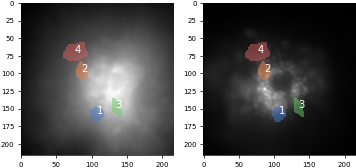

In [466]:
%matplotlib inline
fig1, axes = plt.subplots(1,2, figsize=(6,3))
q = visualize.display_roi_overlay(mean_intensity, full_clicky_rois.astype(int), ax=axes[0], mask_cmap=colors.ListedColormap(['#4878d0', '#ee854a', '#6acc64', '#d65f5f']))
q2 = visualize.display_roi_overlay(nkx_downsample, full_clicky_rois.astype(int), ax=axes[1], mask_cmap=colors.ListedColormap(['#4878d0', '#ee854a', '#6acc64', '#d65f5f']))

In [534]:
traces = []
for i in range(1, np.max(full_clicky_rois)+1):
    traces.append(images.extract_mask_trace(img, mask=full_clicky_rois==i))
traces = np.array(traces)

In [535]:
traces.shape

(4, 2191)

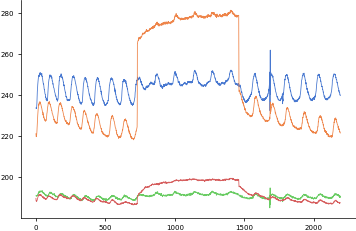

In [536]:
plt.plot(traces.T)

Check optical crosstalk

In [312]:
stim_edges = np.argwhere(np.diff(traces_dict["enable488"]) != 0).ravel()

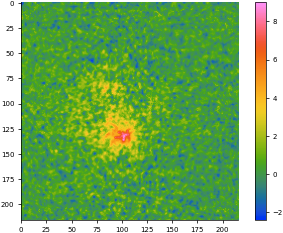

In [127]:
idx = stim_edges[0]+1
n_frames_mean = 5
before = img[idx-n_frames_mean:idx,:,:].astype(int).mean(axis=0)
during = img[idx:idx+n_frames_mean,:,:].astype(int).mean(axis=0)
im = plt.imshow(during-before)
plt.colorbar(im)

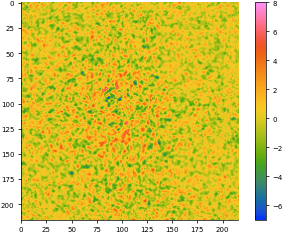

In [19]:
im = plt.imshow(img[stim_edges[0]+1].astype(int)-img[stim_edges[0]-1].astype(int))
plt.colorbar(im)

In [59]:
traces_crosstalk_removed = np.copy(traces)
# delta = (traces_crosstalk_removed[:,stim_edges[0]+2] - traces_crosstalk_removed[:,stim_edges[0]+1])[:,np.newaxis]
delta = (traces_crosstalk_removed[:,stim_edges[1]] - traces_crosstalk_removed[:,stim_edges[1]+1])[:,np.newaxis]
traces_crosstalk_removed[:,stim_edges[0]+2:stim_edges[1]+1] -= delta


# traces_crosstalk_removed = traces

(1439.0, 1459.0)

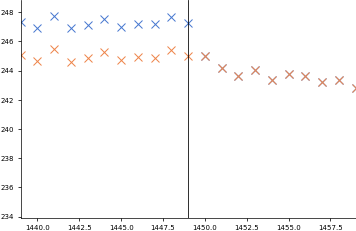

In [21]:
fig1, ax1 = plt.subplots(figsize=(6,4))
ax1.plot(traces[0,:], "x")
ax1.plot(traces_crosstalk_removed[0,:], "x")
ax1.axvline(stim_edges[1], color="k")
ax1.set_xlim(stim_edges[1]-10,stim_edges[1]+10)

(1400.0, 1600.0)

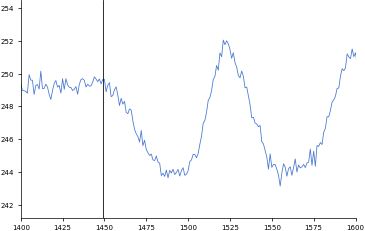

In [183]:
fig1, ax1 = plt.subplots(figsize=(6,4))
ax1.plot(traces[4,:])
ax1.axvline(stim_edges[1], color="k")
ax1.set_xlim(1400,1600)

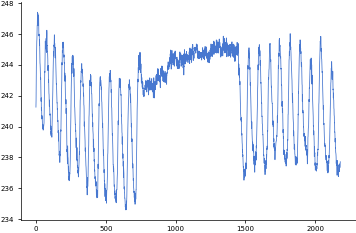

In [191]:
plt.plot(traces_crosstalk_removed[0,:])
# plt.ylim(232, 240)
# plt.xlim(500, 1000)

In [60]:
normalized_traces = np.divide((traces_crosstalk_removed - np.min(traces_crosstalk_removed[:,stim_edges[1]+200:], axis=1)[:,np.newaxis]), (np.max(traces_crosstalk_removed[:,stim_edges[1]+200:], axis=1) - \
                                                               np.min(traces_crosstalk_removed[:,stim_edges[1]+200:], axis=1))[:,np.newaxis])

In [61]:
before_trace = normalized_traces[:,:stim_edges[0]-int(4/dt)]
after_trace = normalized_traces[:,stim_edges[1]+int(4/dt):]
during_trace = normalized_traces[:,stim_edges[0]+int(2/dt):stim_edges[1]-int(2/dt)]


In [62]:
def find_pks_along_axis(dat, plot=False, offset=1):
    def auto_prom_pks(x):
        x1 = x - np.mean(x)
        if 1/dt > 20:
            sos = signal.butter(5, 10, fs=1/dt, output='sos')
            x1 = signal.sosfiltfilt(sos, x1)
#         print(x1)
        prom = max((np.percentile(x1, 90) - np.percentile(x1, 10))*0.4, 0.3)
#         pks = signal.find_peaks(x1,prominence=prom, width=(20,None))
        pks = signal.find_peaks(x1,prominence=prom, width=(3,None))
        return pks
    pks = np.apply_along_axis(lambda x: auto_prom_pks(x), 1, dat)[:,0]
    if plot:
        fig1, ax1 = plt.subplots(figsize=(8, 1*dat.shape[0]))
        for i in range(len(pks)):
            ax1.plot(dat[i,:]+i*offset)
            ax1.plot(pks[i], dat[i,pks[i]]+i*offset, "kx")
    return pks

In [63]:
traces_by_time_window = [before_trace, during_trace, after_trace]
freqs = []

In [64]:
def stackplot(y, xvals=None, figsize_single=(12,1), ax=None, offset=None, cmap=None, flipud=False):
    if offset is None:
        offset = np.max(np.max(y, axis=1) - np.min(y, axis=1))
    if ax is None:
        fig1, ax = plt.subplots(figsize=(figsize_single[0],figsize_single[1]*y.shape[0]))
    else:
        fig1 = ax.figure
    if cmap is None:
        cmap = plt.rcParams['axes.prop_cycle'].by_key()['color']
    elif isinstance(cmap, mpl.colors.Colormap):
        cmap = [cmap(i/y.shape[0]) for i in range(y.shape[0])]
    cs = []
    yplot = y
    print(cmap)
    if flipud:
        yplot = np.flipud(y)
        cmap = cmap[::-1]
    for i in range(y.shape[0]):
        color = cmap[i%len(cmap)]
        if xvals is None:
            ax.plot(yplot[i,:] + i*offset, color=color)
        else:
            ax.plot(xvals, yplot[i,:] + i*offset, color=color)
        cs.append(color)
    if flipud:
        cs = cs[::-1]
    return fig1, ax, cs

In [575]:
props = measure.regionprops_table(full_clicky_rois, properties=['centroid'])

In [576]:
centroids = np.array([props['centroid-0'], props['centroid-1']]).T
sqdist = np.sum((centroids - centroids[0,:])**2, axis=1)

In [596]:
ntraces_sorted = normalized_traces[np.argsort(sqdist),:]

In [65]:
def display_roi_overlay(img, mask, textcolor="white", alpha=0.5, ax=None, cmap="gray", mask_cmap="viridis"):
    """ Display an image with a labelled integer valued overlay
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 12))
    else:
        fig = ax.figure
        
    props = measure.regionprops(mask)
    mask = np.ma.masked_where(mask==0, mask)
        
    im = ax.imshow(img, cmap=cmap)
    ax.imshow(mask, interpolation='none', alpha=alpha, cmap=mask_cmap, vmin=1, vmax = np.max(mask))
    if textcolor is not None:
        for idx, obj in enumerate(props):
            centroid = obj.centroid
            ax.text(centroid[1], centroid[0], str(idx+1), color=textcolor)
    return fig, ax, im

In [66]:
def plot_scalebar(fig, ax, x0, y0, length_um, thickness_px, pix_per_um = 1, fontsize=9, \
                  color="white", unit="\mu m", yax_direction="down", text_pos="below", scale=0.7,
                 show_label=True):
    rect = patches.Rectangle((x0,y0), length_um*pix_per_um, thickness_px, color=color)
    ax.add_patch(rect)
    
    if show_label:
        plt.draw()
        label = r"$%d \mathrm{%s}$" % (length_um, unit)
        tx = ax.text(x0, y0, label, fontsize=fontsize, color=color)
        bb = tx.get_window_extent(renderer=fig.canvas.renderer)
        transf = ax.transData.inverted()
        bb_datacoords = bb.transformed(transf)
        bb_width = bb_datacoords.x1 - bb_datacoords.x0
        bb_height = bb_datacoords.y1 - bb_datacoords.y0

        x0_text = x0 + ((length_um*pix_per_um)-bb_width)/2

        if yax_direction == "down":
            diff = bb_height*scale
        elif yax_direction == "up":
            diff = -bb_height*scale
        if text_pos == "above":
            diff = -diff
        y0_text = y0 + diff
        tx.set_position((x0_text, y0_text))
        plt.draw()

[(0.21566, 0.71777, 0.92594, 1.0), (0.26866, 0.72496, 0.83996, 1.0), (0.31753, 0.73071, 0.74772, 1.0), (0.36781, 0.73379, 0.65532, 1.0), (0.43504, 0.73236, 0.55536, 1.0), (0.5299, 0.72164, 0.46164, 1.0), (0.63421, 0.70085, 0.4023, 1.0), (0.7338, 0.67294, 0.37065, 1.0), (0.81969, 0.64126, 0.36896, 1.0), (0.89885, 0.60429, 0.39088, 1.0)]


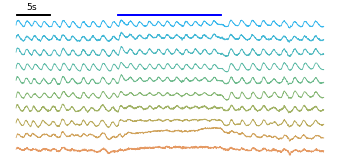

In [67]:
cmap = plt.get_cmap("cet_CET_I1")
plt.close("all")
xvals = dt*np.arange(normalized_traces.shape[1])
fig1, ax = plt.subplots(figsize=(5,2.5))
q = stackplot(normalized_traces, xvals=xvals, offset=1.8, figsize_single=(4,0.5), \
              ax=ax, cmap=cmap, flipud=True)
ax.set_ylim((-0.5, 18))
visualize.plot_img_scalebar(fig1, ax, 0, 17.8, 5, 0.25, yax_direction="up", color="k", \
              unit="s", text_pos="above", scale=0.5)
visualize.plot_img_scalebar(fig1, ax, stim_edges[0]*dt, 17.8, (stim_edges[1]-stim_edges[0])*dt, 0.25,\
              yax_direction="up", color="blue", show_label=False)
plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(rootdir, "analysis", "clicky_traces_not_loi.svg"))

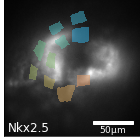

In [616]:
plt.close("all")
fig1, ax1 = plt.subplots(figsize=(2.5,2.5))
q2 = display_roi_overlay(nkx_downsample, full_clicky_rois.astype(int), ax=ax1, \
                         mask_cmap=colors.ListedColormap(np.array(q[2], dtype=object)), textcolor=None)
ax1.set_xlim((15,175))
ax1.set_ylim((15,175))
plot_scalebar(fig1, ax1, 120, 30, 50, 3, pix_per_um=((1/0.265)/4), yax_direction="up")
ax1.text(20, 20, "Nkx2.5", fontsize=12, color="white")
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
# plt.savefig(os.path.join(rootdir, "analysis", "clicky_rois_example_loi.tif"), dpi=300)

In [620]:
traces_by_time_window[0].shape

(10, 524)

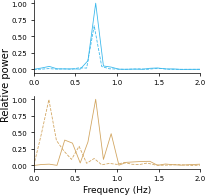

In [68]:
fig1, axes = plt.subplots(2,1, figsize=(3,3))
before_trace_target = traces_by_time_window[0][0]
N = len(before_trace_target)
yf = fft.fft(before_trace_target-np.mean(before_trace_target))
xf_before = fft.fftfreq(N, dt)[:N//2]

yft_before = (2.0/N*np.abs(yf[0:N//2]))**2

during_trace_target = traces_by_time_window[1][0]
N = len(during_trace_target)
yf = fft.fft(during_trace_target-np.mean(during_trace_target))
xf_during = fft.fftfreq(N, dt)[:N//2]

yft_during = (2.0/N*np.abs(yf[0:N//2]))**2

axes[0].plot(xf_before, yft_before/np.max(yft_before), color=q[2][0])
axes[0].plot(xf_during, yft_during/np.max(yft_before), color=q[2][0], ls="--")


before_trace_offtarget = traces_by_time_window[0][-2]
N = len(before_trace_offtarget)
yf = fft.fft(before_trace_offtarget-np.mean(before_trace_offtarget))
xf_before = fft.fftfreq(N, dt)[:N//2]

yft_before = (2.0/N*np.abs(yf[0:N//2]))**2


during_trace_offtarget = traces_by_time_window[1][-2]
N = len(during_trace_offtarget)
yf = fft.fft(during_trace_offtarget-np.mean(during_trace_offtarget))
xf_during = fft.fftfreq(N, dt)[:N//2]

yft_during = (2.0/N*np.abs(yf[0:N//2]))**2

axes[1].plot(xf_before, yft_before/np.max(yft_before), color=q[2][-2])
axes[1].plot(xf_during, yft_during/np.max(yft_before), color=q[2][-2], ls="--")

axes[0].set_xlim((0, 2))

axes[1].set_xlim((0, 2))
axes[1].set_xlabel("Frequency (Hz)")
fig1.text(0, 0.4, "Relative power", rotation=90)
plt.tight_layout()
plt.savefig(os.path.join(rootdir, "analysis", "example_freq_shift_not_loi.svg"))

ValueError: x and y must have same first dimension, but have shapes (3,) and (0,)

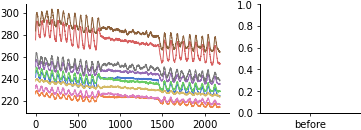

In [332]:
xvals = dt*np.arange(normalized_traces.shape[1])
fig1, axes = plt.subplots(1,2, figsize=(6,2), gridspec_kw={"width_ratios":[4,2]})
q = stackplot(traces, offset=1, figsize_single=(4,0.5), ax=axes[0])
axes[1].plot(["before", "during", "after"], freqs)
ax1.set_xlabel("Time (s)")
# ax1.set_ylim(-1, 13)
axes[0].set_ylabel("Intensity (AU)")
axes[1].set_ylabel("Frequency (Hz)")
axes[1].set_ylim((0,1))
plt.tight_layout()
plt.savefig(os.path.join(rootdir, "analysis", "%s_clicky.svg" % filename))

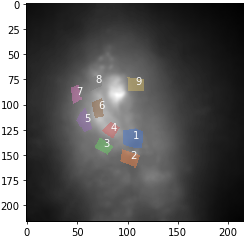

In [334]:
fig1, ax1 = plt.subplots(figsize=(4,4))
q = display_roi_overlay(mean_intensity, full_clicky_rois.astype(int), ax=ax1, mask_cmap=colors.ListedColormap(['#4878d0', '#ee854a', '#6acc64', '#d65f5f', '#956cb4', '#8c613c', '#dc7ec0', '#797979', '#d5bb67', '#82c6e2']))

In [520]:
skio.imsave(os.path.join(rootdir, "analysis", "%s_clicky_mask.tif" %filename), full_clicky_rois)
# skio.imsave(os.path.join(rootdir, "analysis", "intensity_propagation_mask.tif"), full_clicky_rois)

/tmp/ipykernel_65961/1714221348.py:1: UserWarning: /n/holyscratch01/cohen_lab/bjia/20220222_gtacr_targeted_silencing/analysis/112511E18_target1_clicky_mask.tif is a low contrast image
  skio.imsave(os.path.join(rootdir, "analysis", "%s_clicky_mask.tif" %filename), full_clicky_rois)


### Analysis of frequency shifts in paired target spots

In [475]:
def get_dmd_target_scaled(expt_data, img, factor=4):
    target_img_space = expt_data["dmd_lightcrafter"]['target_image_space']
    target_img_space = target_img_space[::factor,::factor]
    offset = [(target_img_space.shape[0]-img.shape[1])//2, (target_img_space.shape[1]-img.shape[2])//2]
    target_img_space = target_img_space[offset[0]:-offset[0],offset[1]:-offset[1]]
    target_img_space = target_img_space.astype(bool)
    return target_img_space

In [476]:
def get_normalized_traces(img, rois, traces_dict, dt, start_frames_removed=10):
    traces = []
    for i in range(1, np.max(rois)+1):
        traces.append(images.extract_mask_trace(img, mask=rois==i))
    traces = np.array(traces)
    
    stim_edges = np.argwhere(np.diff(traces_dict["enable488"]) != 0).ravel()-10
    traces_crosstalk_removed = np.copy(traces)
    traces_crosstalk_removed[:,stim_edges[0]+2:stim_edges[1]+1] -= \
                                (traces_crosstalk_removed[:,stim_edges[1]] -\
                                 traces_crosstalk_removed[:,stim_edges[1]+1])[:,np.newaxis]
    normalized_traces = np.divide((traces_crosstalk_removed - np.min(traces_crosstalk_removed[:,stim_edges[1]+200:], axis=1)[:,np.newaxis]), (np.max(traces_crosstalk_removed[:,stim_edges[1]+200:], axis=1) - \
                                                               np.min(traces_crosstalk_removed[:,stim_edges[1]+200:], axis=1))[:,np.newaxis])
    
    before_trace = normalized_traces[:,:stim_edges[0]-int(4/dt)]
    after_trace = normalized_traces[:,stim_edges[1]+int(4/dt):]
    during_trace = normalized_traces[:,stim_edges[0]+int(2/dt):stim_edges[1]-int(2/dt)]
    return normalized_traces, (before_trace, during_trace, after_trace)

In [477]:
def apply_ft_along_axis(arr, dt):
    N = arr.shape[1]
    yabs = np.apply_along_axis(lambda x: 2.0/N*np.abs(fft.fft(x)[:N//2]), \
                                      1, arr-np.mean(arr, axis=1)[:,np.newaxis])
    xf = fft.fftfreq(N, dt)[:N//2]
    return xf, yabs
def get_paired_frequency_spectra(before_traces, during_traces, dt):
    xf_before, yabs_before = apply_ft_along_axis(before_traces, dt)
    xf_during, yabs_during = apply_ft_along_axis(during_traces, dt)
    
    return xf_before, yabs_before, xf_during, yabs_during


105105E17_target1
105229E17_target2
105454E17_target1_orange_target
105650E17_target1_orange_target_2V
105833E17_target1_2V
105957E17_target2_2V
110131E17_target3_2V
110306E17_target4_2V
110500E17_target5_2V


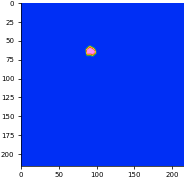

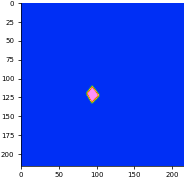

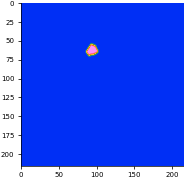

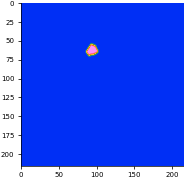

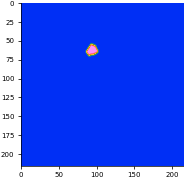

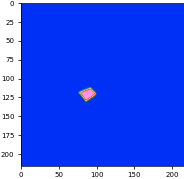

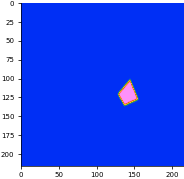

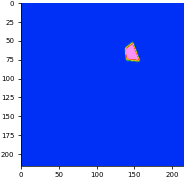

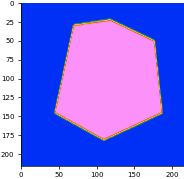

In [48]:
embryo = 17
for filename in list(expt_info["file_name"]):
    if "E%d" % embryo in filename and "target" in filename:
        try:
            expt_data = mat73.loadmat(os.path.join(rootdir, filename, "output_data_py.mat"))["dd_compat_py"]
        except Exception:
            continue
        print(filename)
        factor = 4
        target_img_space = expt_data["dmd_lightcrafter"]['target_image_space']
        target_img_space = target_img_space[::factor,::factor]
        offset = [(target_img_space.shape[0]-216)//2, (target_img_space.shape[1]-216)//2]
        target_img_space = target_img_space[offset[0]:-offset[0],offset[1]:-offset[1]]
        fig1, ax1 = plt.subplots(figsize=(3,3))
        ax1.imshow(target_img_space)

In [22]:
expt_info["file_name"]

0           094238E16_endogenous_activity
1             102002E16_silencing_target2
2             102209E16_silencing_target1
3             102551E16_silencing_target3
4             102758E16_silencing_target4
5             103001E16_silencing_target5
6             103123E16_silencing_target6
7             103247E16_silencing_fullfov
8     103538E16_silencing_targeted_orange
9                    103940E17_endogenous
10                      105105E17_target1
11                      105229E17_target2
12        105454E17_target1_orange_target
13     105650E17_target1_orange_target_2V
14                   105833E17_target1_2V
15                   105957E17_target2_2V
16                   110131E17_target3_2V
17                   110306E17_target4_2V
18                   110500E17_target5_2V
19                   110849E18_endogenous
20        112307E18_target1_orange_target
21                      112511E18_target1
22                 112800E18_target1_0.5V
23                   113040E18_tar

In [195]:
pairs = [("102002E16_silencing_target2", "102551E16_silencing_target3"), \
         ("105833E17_target1_2V", "105957E17_target2_2V"), ("112511E18_target1", "113430E18_target2_0.7V"), \
         ("115544E8_target1", "115726E8_target2"), ("115544E8_target1", "120018E8_target2_2V"), \
         ("120018E8_target2_2V", "115854E8_target3")]
start_frames_removed = [10,10,10,10,10]

/n/home11/bjia/notebooks/../SpikeCounter/spikecounter/analysis/images.py:37: UserWarning: 10 frames dropped
  warnings.warn("%d frames dropped" % (fc_max - img.shape[0]))
/n/home11/bjia/notebooks/../SpikeCounter/spikecounter/analysis/images.py:37: UserWarning: 10 frames dropped
  warnings.warn("%d frames dropped" % (fc_max - img.shape[0]))
/n/home11/bjia/notebooks/../SpikeCounter/spikecounter/analysis/images.py:37: UserWarning: 10 frames dropped
  warnings.warn("%d frames dropped" % (fc_max - img.shape[0]))
/n/home11/bjia/notebooks/../SpikeCounter/spikecounter/analysis/images.py:37: UserWarning: 10 frames dropped
  warnings.warn("%d frames dropped" % (fc_max - img.shape[0]))
/n/home11/bjia/notebooks/../SpikeCounter/spikecounter/analysis/images.py:37: UserWarning: 10 frames dropped
  warnings.warn("%d frames dropped" % (fc_max - img.shape[0]))
/n/home11/bjia/notebooks/../SpikeCounter/spikecounter/analysis/images.py:37: UserWarning: 10 frames dropped
  warnings.warn("%d frames dropped" %

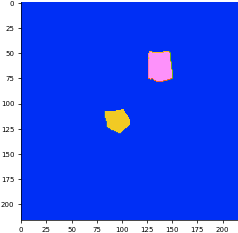

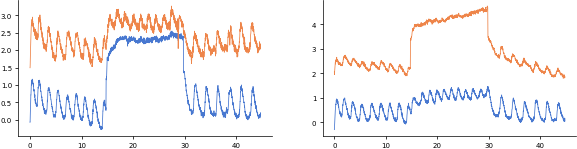

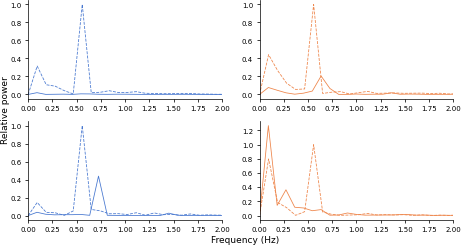

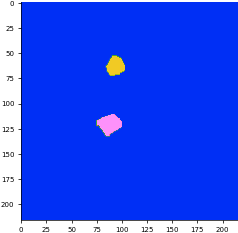

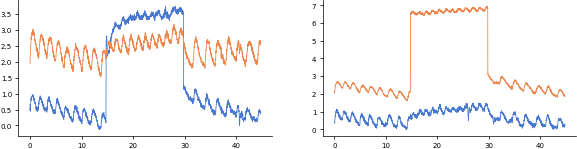

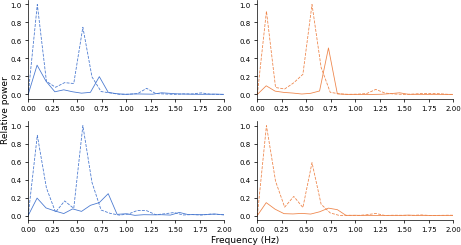

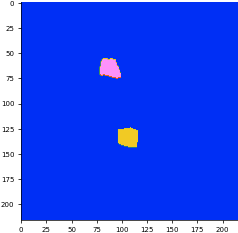

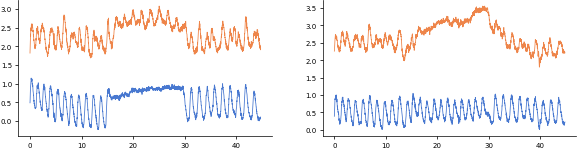

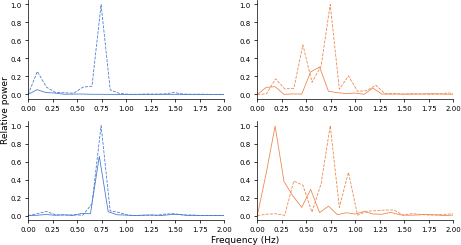

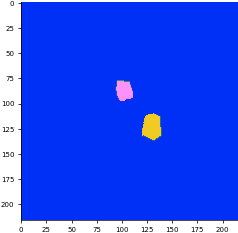

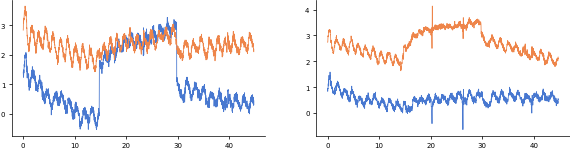

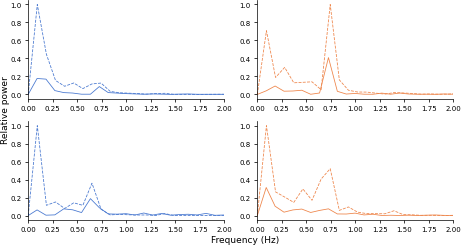

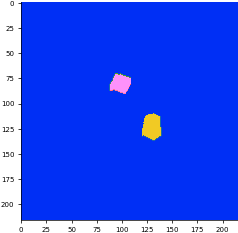

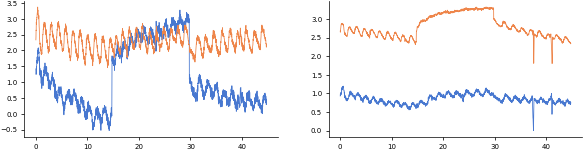

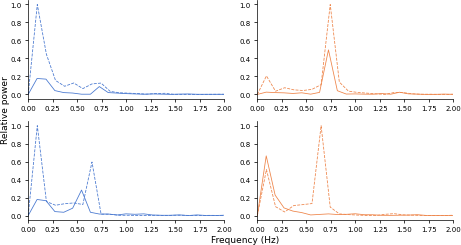

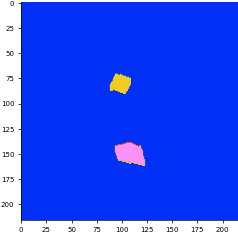

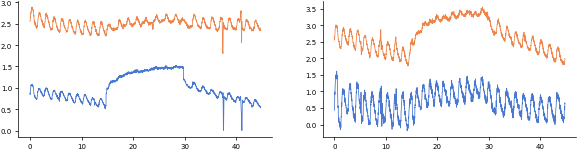

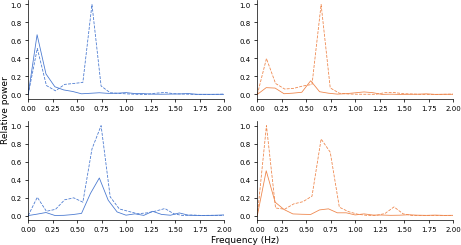

In [200]:
for idx, pair in enumerate(pairs):
    embryo = parse.search("E{:d}_", pair[0])[0]
    img1, expt_data1 = images.load_image(rootdir, pair[0], subfolder="downsampled")
    img2, expt_data2 = images.load_image(rootdir, pair[1], subfolder="downsampled")
    img1 = images.correct_photobleach(img1, method="linear")
    img2 = images.correct_photobleach(img2, method="linear")
    trace_dict1, dt1 = utils.traces_to_dict(expt_data1)
    trace_dict2, dt2 = utils.traces_to_dict(expt_data2)
    
    paired_targets = get_dmd_target_scaled(expt_data1, img1).astype(int) + \
                        get_dmd_target_scaled(expt_data2, img2).astype(int)*2
    fig1, ax1 = plt.subplots(figsize=(4,4))
    ax1.imshow(paired_targets)
    
    nt1, nt1_split = get_normalized_traces(img1, paired_targets, trace_dict1, dt1)
    nt2, nt2_split = get_normalized_traces(img2, paired_targets, trace_dict2, dt2)
    
    xvals1 = np.arange(nt1.shape[1])*dt1
    xvals2 = np.arange(nt2.shape[1])*dt2
    
    fig1, axes = plt.subplots(1, 2, figsize=(10,2.5))
    q = visualize.stackplot(nt1, xvals=xvals1, offset=1.8, figsize_single=(4,0.5), ax=axes[0])
    q = visualize.stackplot(nt2, xvals=xvals2, offset=1.8, figsize_single=(4,0.5), ax=axes[1])
    
    xf_before, yabs_before, xf_during, yabs_during = get_paired_frequency_spectra(nt1_split[0], nt1_split[1], dt1)
    
    yabs_before = yabs_before**2
    yabs_during = yabs_during**2
        
    fig1, axes = plt.subplots(2,2, figsize=(6.5, 3.5))
    axes[0][0].plot(xf_before, yabs_before[0,:]/np.max(yabs_before[0,:]), color="C0", ls="--")
    axes[0][1].plot(xf_before, yabs_before[1,:]/np.max(yabs_before[1,:]), color="C1", ls="--")

    axes[0][0].plot(xf_during, yabs_during[0,:]/np.max(yabs_before[0,:]), color="C0")
    axes[0][1].plot(xf_during, yabs_during[1,:]/np.max(yabs_before[1,:]), color="C1")

    
    xf_before, yabs_before, xf_during, yabs_during = get_paired_frequency_spectra(nt2_split[0], nt2_split[1], dt2)
    yabs_before = yabs_before**2
    yabs_during = yabs_during**2
    axes[1][0].plot(xf_before, yabs_before[0,:]/np.max(yabs_before[0,:]), color="C0", ls="--")
    axes[1][1].plot(xf_before, yabs_before[1,:]/np.max(yabs_before[1,:]), color="C1", ls="--")

    axes[1][0].plot(xf_during, yabs_during[0,:]/np.max(yabs_before[0,:]), color="C0")
    axes[1][1].plot(xf_during, yabs_during[1,:]/np.max(yabs_before[1,:]), color="C1")

    for ax in axes.ravel():
        ax.set_xlim((0, 2))
    fig1.text(0, 0.4, "Relative power", rotation=90)
    fig1.text(0.45,0, "Frequency (Hz)")
    plt.tight_layout()
    plt.savefig(os.path.join(rootdir, "analysis", "E%d_idx%d_power_spectra.svg" % (embryo, idx)))

### Map wave propagation before/after/during silencing

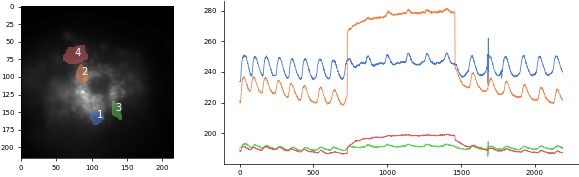

In [537]:
%matplotlib inline
fig1, axes = plt.subplots(1,2, figsize=(10,3), gridspec_kw={"width_ratios":(3,7)})
q2 = visualize.display_roi_overlay(nkx_downsample, full_clicky_rois.astype(int), ax=axes[0], \
                                   mask_cmap=colors.ListedColormap(['#4878d0', '#ee854a', '#6acc64', '#d65f5f']))
axes[1].plot(traces.T)

Before silencing

In [538]:
dt = np.mean(np.diff(t))

In [539]:
before_stim_img = img[:stim_edges[0]-int(1/dt),:,:]

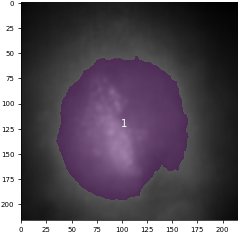

In [540]:
mean_img = before_stim_img.mean(axis=0)
fig1, ax1 = plt.subplots(figsize=(4,4))
ax1.imshow(mean_img)
intensity_mask = mean_img > np.percentile(mean_img, 70)
q = visualize.display_roi_overlay(mean_img, intensity_mask.astype(int), ax=ax1)

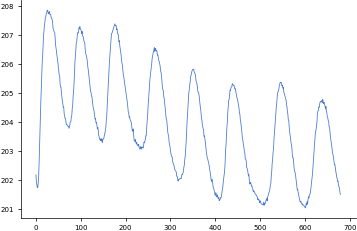

In [541]:
mean_trace = images.extract_mask_trace(before_stim_img, mask=intensity_mask)
plt.plot(mean_trace)

In [542]:
nsamps = (int(2.5/dt)//2)*2 +1
pb_corrected_img = images.correct_photobleach(before_stim_img, mask=intensity_mask, method="localmin", nsamps=nsamps)
# pb_corrected_img = images.correct_photobleach(before_stim_img, mask=intensity_mask, method="decorrelate")
mean_img = pb_corrected_img.mean(axis=0)
t_zeroed = pb_corrected_img - mean_img

data_matrix = t_zeroed.reshape((t_zeroed.shape[0], -1))
sos = signal.butter(5,[17,19],btype="bandstop", output="sos", fs = 1/dt)
data_matrix_filtered = np.apply_along_axis(lambda x: signal.sosfiltfilt(sos, x), 0, data_matrix)
denoised = sstats.denoise_svd(data_matrix_filtered, 30, skewness_threshold=0)
denoised = denoised.reshape(before_stim_img.shape)
denoised += mean_img
dFF_before = images.get_image_dFF(denoised)

(680, 216, 216)


/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/sklearn/utils/extmath.py:368: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(


In [543]:
dFF_trace = images.extract_mask_trace(dFF_before, mask=full_clicky_rois==3)

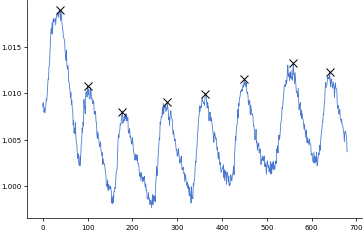

In [544]:
pks, _ = signal.find_peaks(dFF_trace, prominence=0.005, width=(5,None))
plt.plot(dFF_trace)
plt.plot(pks, dFF_trace[pks], "kx")

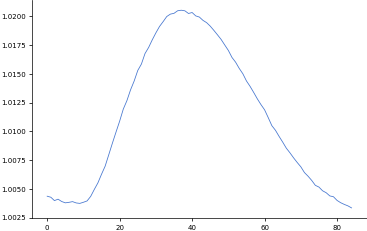

In [545]:
sta_before = images.spike_triggered_average_video(dFF_before, pks,45, 40)
sta_trace = images.extract_mask_trace(sta_before, mask=intensity_mask)
plt.plot(sta_trace)

In [546]:
skio.imsave(os.path.join(rootdir, "analysis", embryo, "%s_sta_before.tif" % filename), np.flip(sta_before, axis=1))
utils.display_zstack(np.flip(sta_before, axis=1)[:,:,:, np.newaxis], c=0, pct_cutoffs=[0,100])

/tmp/ipykernel_131585/522329692.py:1: UserWarning: /n/holyscratch01/cohen_lab/bjia/20220301_gtacr_targeted_silencing/analysis/E3/120840gtacr_E3_target2_2V_sta_before.tif is a low contrast image
  skio.imsave(os.path.join(rootdir, "analysis", embryo, "%s_sta_before.tif" % filename), np.flip(sta_before, axis=1))


interactive(children=(IntSlider(value=42, description='z', max=84), Dropdown(description='c', options=('all', …

[4.50000000e+01 3.03873841e+01 1.00831285e+00 1.03330169e-05]


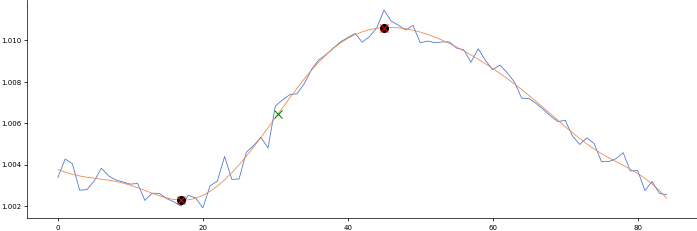

In [547]:
s = 0.0
n_knots = 10
beta, spl = images.spline_fit_single_trace(sta_before[:,110,125], s,\
                               np.linspace(0, sta_before.shape[0]-1, num=n_knots)[1:-1], plot=True)
print(beta)

In [548]:
beta_before, smoothed_vid = images.spline_timing(sta_before, s=0.05, n_knots=10)
skio.imsave(os.path.join(rootdir, "analysis", embryo, "%s_spline_smoothed_vid_before.tif" % filename), smoothed_vid)
np.savez(os.path.join(rootdir, "analysis", embryo, "%s_snapt_before.npz") % filename,\
         beta=beta_before)

/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/numpy/lib/shape_base.py:379: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = asanyarray(func1d(inarr_view[ind0], *args, **kwargs))
/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/numpy/lib/shape_base.py:402: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  buff[ind] = asanyarray(func1d(inarr_view[ind], *args, **kwargs))
/tmp/ipykernel_131585/1284110549.py:2: UserWarning: /n/holyscratch01/cohen_lab/bjia/20220301_gtacr_targeted_silencing/analysis/E3/120840gtacr_E3_target2_2V_spl

In [549]:
def process_isochrones(beta, dt, pct_threshold=50, plot=False):
    """ Clean up spline fitting to better visualize isochrones: get rid of nans and low-amplitude values 
    """
    amplitude = beta[2,:,:]
    amplitude_nan_removed = np.copy(amplitude)
    minval = np.nanmin(amplitude)
    amplitude_nan_removed[np.isnan(amplitude)] = minval
    thresh = np.percentile(amplitude_nan_removed,pct_threshold)
    # thresh = filters.threshold_otsu(amplitude_nan_removed)
    mask = amplitude_nan_removed>thresh
    mask = morphology.binary_opening(mask, footprint=morphology.disk(2))
    mask = morphology.binary_closing(mask, footprint=morphology.disk(2))
    
    if plot:
        fig1, ax1 = plt.subplots(figsize=(3,3))
        visualize.display_roi_overlay(amplitude_nan_removed, mask.astype(int), ax = ax1)
    
    hm = beta[1,:,:]
    average_regional_nans = ndimage.convolve(np.isnan(hm), np.ones((3,3)))
    convinput = np.copy(hm)
    convinput[np.isnan(hm)] = 0
    kernel = np.ones((3,3))
    kernel[1,1] = 0
    hm_nans_removed = np.copy(hm)
    hm_nans_removed[np.isnan(hm)] = ndimage.convolve(convinput,kernel)[np.isnan(hm)]
    
    hm_smoothed = ndimage.median_filter(hm_nans_removed, size=3)
    hm_smoothed = ndimage.gaussian_filter(hm_smoothed, sigma=1)
    hm_nan = np.copy(hm_smoothed)
    hm_nan[~mask] = np.nan
    hm_nan = (hm_nan-np.nanmin(hm_nan))*dt*1000
    
    return hm_nan

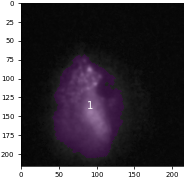

In [550]:
hm_nan = process_isochrones(beta_before, dt, plot=True, pct_threshold=80)

In [551]:
np.percentile(hm_nan[~np.isnan(hm_nan)],10)

5.4804282742328034e+01

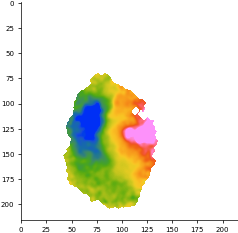

In [552]:
plt.imshow(hm_nan, vmin=np.percentile(hm_nan[~np.isnan(hm_nan)],5), \
               vmax=np.percentile(hm_nan[~np.isnan(hm_nan)],95))

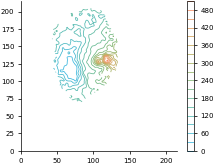

In [553]:
fig1, ax1 = plt.subplots(figsize=(3.5,2.75))

im = ax1.contour(hm_nan, vmin=np.percentile(hm_nan[~np.isnan(hm_nan)],0), \
               vmax=np.percentile(hm_nan[~np.isnan(hm_nan)],100), levels=16, \
                 cmap = plt.get_cmap("cet_CET_I1"))
plt.colorbar(im)

After silencing is over

In [554]:
after_stim_img = img[stim_edges[1]+int(1/dt):,:,:]

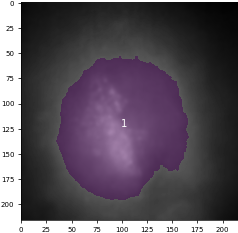

In [555]:
mean_img = after_stim_img.mean(axis=0)
fig1, ax1 = plt.subplots(figsize=(4,4))
ax1.imshow(mean_img)
intensity_mask = mean_img > np.percentile(mean_img, 70)
q = visualize.display_roi_overlay(mean_img, intensity_mask.astype(int), ax=ax1)

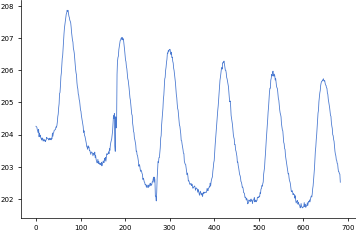

In [556]:
mean_trace = images.extract_mask_trace(after_stim_img, mask=intensity_mask)
plt.plot(mean_trace)

In [557]:
nsamps = (int(2.5/dt)//2)*2 +1
pb_corrected_img = images.correct_photobleach(after_stim_img, mask=intensity_mask, method="localmin", nsamps=nsamps)
# pb_corrected_img = images.correct_photobleach(before_stim_img, mask=intensity_mask, method="decorrelate")
mean_img = pb_corrected_img.mean(axis=0)
t_zeroed = pb_corrected_img - mean_img

data_matrix = t_zeroed.reshape((t_zeroed.shape[0], -1))
sos = signal.butter(5,[17,19],btype="bandstop", output="sos", fs = 1/dt)
data_matrix_filtered = np.apply_along_axis(lambda x: signal.sosfiltfilt(sos, x), 0, data_matrix)
denoised = sstats.denoise_svd(data_matrix_filtered, 30, skewness_threshold=0)
denoised = denoised.reshape(after_stim_img.shape)
denoised += mean_img
dFF_after = images.get_image_dFF(denoised)

(684, 216, 216)


/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/sklearn/utils/extmath.py:368: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(


In [558]:
dFF_trace_after = images.extract_mask_trace(dFF_after, mask=full_clicky_rois==1)

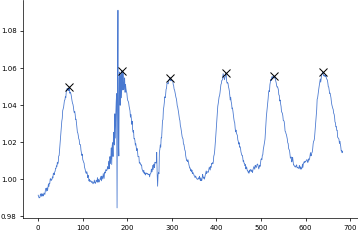

In [561]:
pks, _ = signal.find_peaks(dFF_trace_after, prominence=0.02, width=(10,None))
plt.plot(dFF_trace_after)
plt.plot(pks, dFF_trace_after[pks], "kx")

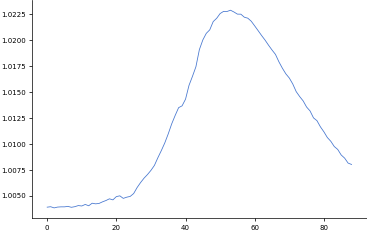

In [562]:
sta_after = images.spike_triggered_average_video(dFF_after, pks, 50, 39)
sta_trace = images.extract_mask_trace(sta_after, mask=intensity_mask)
plt.plot(sta_trace)

In [563]:
utils.display_zstack(np.flip(sta_after, axis=1)[:,:,:, np.newaxis], c=0, pct_cutoffs=[0,100])

interactive(children=(IntSlider(value=44, description='z', max=88), Dropdown(description='c', options=('all', …

In [564]:
skio.imsave(os.path.join(rootdir, "analysis", embryo, "%s_sta_after.tif" % filename), np.flip(sta_after, axis=1))

/tmp/ipykernel_131585/1816560746.py:1: UserWarning: /n/holyscratch01/cohen_lab/bjia/20220301_gtacr_targeted_silencing/analysis/E3/120840gtacr_E3_target2_2V_sta_after.tif is a low contrast image
  skio.imsave(os.path.join(rootdir, "analysis", embryo, "%s_sta_after.tif" % filename), np.flip(sta_after, axis=1))


[6.60000000e+01 4.49526835e+01 1.01255629e+00 2.47850079e-05]


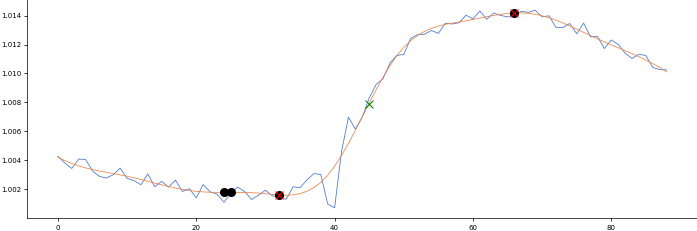

In [565]:
s = 0.0
n_knots = 10
beta, spl = images.spline_fit_single_trace(sta_after[:,110,125], s,\
                               np.linspace(0, sta_after.shape[0]-1, num=n_knots)[1:-1], plot=True)
print(beta)

In [566]:
beta_after, smoothed_vid = images.spline_timing(sta_after, s=0.05, n_knots=10)
skio.imsave(os.path.join(rootdir, "analysis", embryo, "%s_spline_smoothed_vid_after.tif" % filename), smoothed_vid)
np.savez(os.path.join(rootdir, "analysis", embryo, "%s_snapt_after.npz") % filename,\
         beta=beta_after)

/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/numpy/lib/shape_base.py:379: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = asanyarray(func1d(inarr_view[ind0], *args, **kwargs))
/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/numpy/lib/shape_base.py:402: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  buff[ind] = asanyarray(func1d(inarr_view[ind], *args, **kwargs))
/tmp/ipykernel_131585/4020135121.py:2: UserWarning: /n/holyscratch01/cohen_lab/bjia/20220301_gtacr_targeted_silencing/analysis/E3/120840gtacr_E3_target2_2V_spl

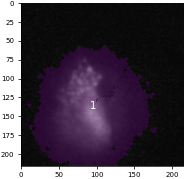

In [567]:
hm_nan = process_isochrones(beta_after, dt, plot=True)

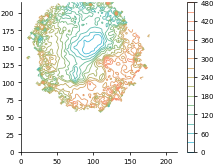

In [568]:
fig1, ax1 = plt.subplots(figsize=(3.5,2.75))

im = ax1.contour(hm_nan, vmin=np.percentile(hm_nan[~np.isnan(hm_nan)],0), \
               vmax=np.percentile(hm_nan[~np.isnan(hm_nan)],99), levels=16, \
                 cmap = plt.get_cmap("cet_CET_I1"))
plt.colorbar(im)

During silencing

In [569]:
during_img = img[stim_edges[0]+int(2/dt):stim_edges[1]-int(0.5/dt),:,:]
during_img -= img[stim_edges[1],:,:] - img[stim_edges[1]+1,:,:]

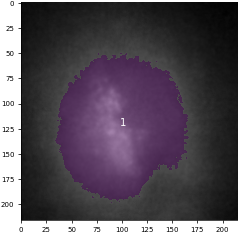

In [570]:
mean_img = during_img.mean(axis=0)
fig1, ax1 = plt.subplots(figsize=(4,4))
ax1.imshow(mean_img)
intensity_mask = mean_img > np.percentile(mean_img, 70)
q = visualize.display_roi_overlay(mean_img, intensity_mask.astype(int), ax=ax1)

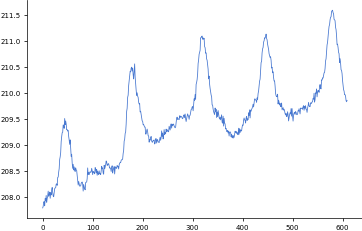

In [571]:
mean_trace = images.extract_mask_trace(during_img, mask=intensity_mask)
plt.plot(mean_trace)

In [572]:
nsamps = (int(2.5/dt)//2)*2 +1
pb_corrected_img = images.correct_photobleach(during_img, mask=intensity_mask, method="localmin", nsamps=nsamps)
# pb_corrected_img = images.correct_photobleach(before_stim_img, mask=intensity_mask, method="decorrelate")
mean_img = pb_corrected_img.mean(axis=0)
t_zeroed = pb_corrected_img - mean_img

data_matrix = t_zeroed.reshape((t_zeroed.shape[0], -1))
sos = signal.butter(5,[17,19],btype="bandstop", output="sos", fs = 1/dt)
data_matrix_filtered = np.apply_along_axis(lambda x: signal.sosfiltfilt(sos, x), 0, data_matrix)
denoised = sstats.denoise_svd(data_matrix_filtered, 30, skewness_threshold=0)
denoised = denoised.reshape(during_img.shape)
denoised += mean_img
dFF_during = images.get_image_dFF(denoised)

(610, 216, 216)


/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/sklearn/utils/extmath.py:368: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(


In [575]:
dFF_trace_during = images.extract_mask_trace(dFF_during, mask=(full_clicky_rois==1))

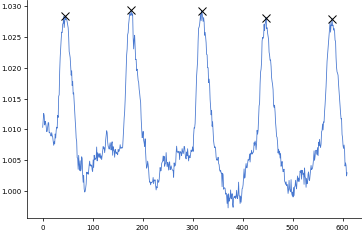

In [576]:
pks, _ = signal.find_peaks(dFF_trace_during, prominence=0.005, width=(5,None))
plt.plot(dFF_trace_during)
plt.plot(pks, dFF_trace_during[pks], "kx")

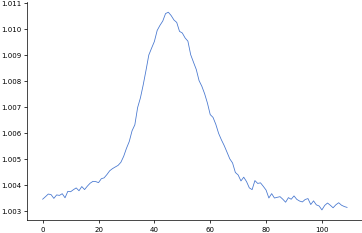

In [577]:
sta_during = images.spike_triggered_average_video(dFF_during, pks, 45, 65)
sta_trace = images.extract_mask_trace(sta_during, mask=intensity_mask)
plt.plot(sta_trace)

In [578]:
skio.imsave(os.path.join(rootdir, "analysis", "%s_sta_during.tif" % filename), np.flip(sta_during, axis=1))
utils.display_zstack(np.flip(sta_during, axis=1)[:,:,:, np.newaxis], c=0, pct_cutoffs=[0,100])

/tmp/ipykernel_131585/3881480316.py:1: UserWarning: /n/holyscratch01/cohen_lab/bjia/20220301_gtacr_targeted_silencing/analysis/120840gtacr_E3_target2_2V_sta_during.tif is a low contrast image
  skio.imsave(os.path.join(rootdir, "analysis", "%s_sta_during.tif" % filename), np.flip(sta_during, axis=1))


interactive(children=(IntSlider(value=54, description='z', max=109), Dropdown(description='c', options=('all',…

[4.60000000e+01 3.58623165e+01 1.01006861e+00 5.06533580e-05]


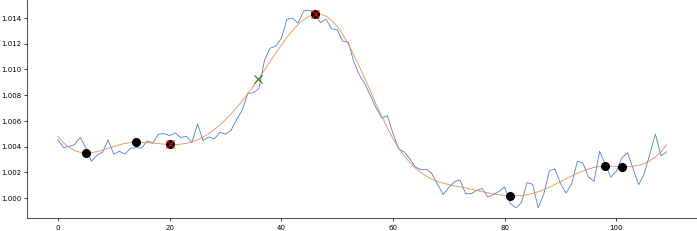

In [579]:
s = 0.05
n_knots = 10
beta, spl = images.spline_fit_single_trace(sta_during[:,150,75], s,\
                               np.linspace(0, sta_during.shape[0]-1, num=n_knots)[1:-1], plot=True)
print(beta)

In [580]:
beta_during, smoothed_vid = images.spline_timing(sta_during, s=0.05, n_knots=10)
skio.imsave(os.path.join(rootdir, "analysis", embryo, "%s_spline_smoothed_vid_during.tif" % filename), smoothed_vid)
np.savez(os.path.join(rootdir, "analysis", embryo, "%s_snapt_during.npz") % filename,\
         beta=beta_during)

/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/numpy/lib/shape_base.py:379: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = asanyarray(func1d(inarr_view[ind0], *args, **kwargs))
/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/numpy/lib/shape_base.py:402: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  buff[ind] = asanyarray(func1d(inarr_view[ind], *args, **kwargs))
/tmp/ipykernel_131585/1009305541.py:2: UserWarning: /n/holyscratch01/cohen_lab/bjia/20220301_gtacr_targeted_silencing/analysis/E3/120840gtacr_E3_target2_2V_spl

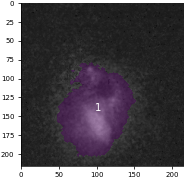

In [581]:
hm_nan = process_isochrones(beta_during, dt, plot=True, pct_threshold=80)

In [582]:
amplitude = beta_during[2,:,:]
amplitude_nan_removed = np.copy(amplitude)
minval = np.nanmin(amplitude)
amplitude_nan_removed[np.isnan(amplitude)] = minval

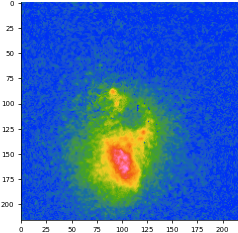

In [583]:
plt.imshow(amplitude_nan_removed, vmin=np.percentile(amplitude_nan_removed, 5), vmax=np.percentile(amplitude_nan_removed, 100))

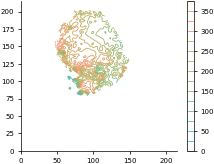

In [584]:
fig1, ax1 = plt.subplots(figsize=(3.5,2.75))

im = ax1.contour(hm_nan, vmin=np.percentile(hm_nan[~np.isnan(hm_nan)],0), \
               vmax=np.percentile(hm_nan[~np.isnan(hm_nan)],99), levels=16, \
                 cmap = plt.get_cmap("cet_CET_I1"))
plt.colorbar(im)

In [585]:
mask_vid = np.tile(full_clicky_rois==9, (sta_during.shape[0],1,1))
skio.imsave(os.path.join(rootdir, "analysis", "not_loi_mask_vid.tif"), mask_vid)

/tmp/ipykernel_131585/521178456.py:2: UserWarning: /n/holyscratch01/cohen_lab/bjia/20220301_gtacr_targeted_silencing/analysis/not_loi_mask_vid.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  skio.imsave(os.path.join(rootdir, "analysis", "not_loi_mask_vid.tif"), mask_vid)
/tmp/ipykernel_131585/521178456.py:2: UserWarning: /n/holyscratch01/cohen_lab/bjia/20220301_gtacr_targeted_silencing/analysis/not_loi_mask_vid.tif is a low contrast image
  skio.imsave(os.path.join(rootdir, "analysis", "not_loi_mask_vid.tif"), mask_vid)


In [186]:
mask_vid = np.tile(full_clicky_rois==1, (100,1,1))
skio.imsave(os.path.join(rootdir, "analysis", "loi_mask_vid.tif"), mask_vid)

/tmp/ipykernel_48073/3174969308.py:2: UserWarning: /n/holyscratch01/cohen_lab/bjia/20220222_gtacr_targeted_silencing/analysis/loi_mask_vid.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  skio.imsave(os.path.join(rootdir, "analysis", "loi_mask_vid.tif"), mask_vid)
/tmp/ipykernel_48073/3174969308.py:2: UserWarning: /n/holyscratch01/cohen_lab/bjia/20220222_gtacr_targeted_silencing/analysis/loi_mask_vid.tif is a low contrast image
  skio.imsave(os.path.join(rootdir, "analysis", "loi_mask_vid.tif"), mask_vid)
